In [1]:
import os
from aicsimageio import AICSImage
from tifffile import imsave
from pathlib import Path
import numpy as np
from skimage.filters import threshold_otsu
from skimage.morphology import ball, binary_closing, remove_small_objects, dilation, erosion, disk
from aicssegmentation.core.pre_processing_utils import  intensity_normalization, edge_preserving_smoothing_3d
from aicssegmentation.core.vessel import vesselness3D
from aicssegmentation.core.seg_dot import dot_2d
from aicssegmentation.core.utils import topology_preserving_thinning, hole_filling
import matplotlib.pyplot as plt
from itkwidgets import view   
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
plt.rcParams["figure.figsize"] = [16, 12]
from aicssegmentation.core.MO_threshold import MO
from aicspylibczi import CziFile
import math
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate


In [2]:
filename = r"\\allen\aics\assay-dev\users\Sandi\nuc-morph-analysis\speckle-analysis\examples\example-3-max-projections\MAX_SEGfinalspeckle_T=328.tiff"

reader = AICSImage(filename) 
IMG = reader.data.astype(np.float32)

print(IMG.shape)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


(1, 1, 1, 258, 170)


In [3]:
#####################
structure_channel = 0

#####################

image = IMG[0,structure_channel,:,:,:].copy()
image_squeeze = np.squeeze(image)
image_squeeze.shape


(258, 170)

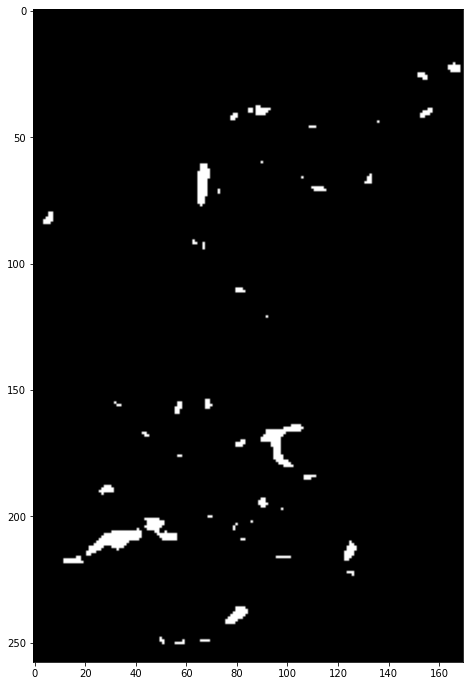

In [4]:
# view(single_fluorescent_view(image))
fig, ax = plt.subplots()
ax.imshow(image_squeeze, cmap=plt.cm.gray)

In [5]:
# getting details for every speckle in the image (stored in dataframe)
label_img = label(image_squeeze)
regions = regionprops(label_img)
props = regionprops_table(label_img,properties=('centroid',
                                             'bbox',
                                             'orientation',
                                             'major_axis_length',
                                             'minor_axis_length',
                                                'area'))

df = pd.DataFrame(props)

In [6]:
df.head()

,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,orientation,major_axis_length,minor_axis_length,area
0,22.800000,166.133333,21,164,25,169,1.398019,5.281634,3.574899,15
1,25.888889,153.555556,25,152,28,156,1.107149,4.618802,2.351779,9
2,39.647059,89.882353,38,88,42,94,1.558484,6.117926,3.865836,17
3,39.500000,85.500000,39,85,41,87,0.785398,2.000000,2.000000,4
4,40.500000,155.000000,39,153,43,158,-1.017222,6.196598,2.366890,12


In [7]:
test = df.shape[0]
test

44

In [8]:
# area for each speckle in image
for i, v in enumerate(df.area):
    print(f"Speckle {i} area: {v}")

Speckle 0 area: 15
Speckle 1 area: 9
Speckle 2 area: 17
Speckle 3 area: 4
Speckle 4 area: 12
Speckle 5 area: 7
Speckle 6 area: 1
Speckle 7 area: 3
Speckle 8 area: 1
Speckle 9 area: 63
Speckle 10 area: 8
Speckle 11 area: 1
Speckle 12 area: 10
Speckle 13 area: 2
Speckle 14 area: 14
Speckle 15 area: 3
Speckle 16 area: 3
Speckle 17 area: 7
Speckle 18 area: 1
Speckle 19 area: 9
Speckle 20 area: 3
Speckle 21 area: 11
Speckle 22 area: 97
Speckle 23 area: 4
Speckle 24 area: 9
Speckle 25 area: 2
Speckle 26 area: 8
Speckle 27 area: 15
Speckle 28 area: 11
Speckle 29 area: 1
Speckle 30 area: 2
Speckle 31 area: 56
Speckle 32 area: 1
Speckle 33 area: 3
Speckle 34 area: 109
Speckle 35 area: 2
Speckle 36 area: 24
Speckle 37 area: 17
Speckle 38 area: 6
Speckle 39 area: 4
Speckle 40 area: 36
Speckle 41 area: 4
Speckle 42 area: 5
Speckle 43 area: 4


In [9]:
# get the total area
print(df['area'].sum())

624


In [10]:
area_list = list(df['area'])
# area_list

In [11]:
# write a function that iterates through each MIP seg image and COUNTS the number of speckles in an image 
input_directory = "/allen/aics/assay-dev/users/Sandi/nuc-morph-analysis/speckle-analysis/examples/example-3-max-projections"

speckle_count_list = []
timepoint_list = []
speckle_count3_df = []
total_area_list = []
avg_area_list = []
count3_tp2_list = list(range(0,312))

for file in os.listdir(input_directory):
    
    structure_channel = 0
    
    # reading in file
    filename = os.path.join(input_directory, file)
    reader = AICSImage(filename) 
    IMG = reader.data.astype(np.float32)
    image = IMG[0,structure_channel,:,:,:].copy()
    image_squeeze = np.squeeze(image)
    
    # creating dataframe with region props 
    label_img = label(image_squeeze)
    regions = regionprops(label_img)
    props = regionprops_table(label_img,properties=('centroid',
                                             'bbox',
                                             'orientation',
                                             'major_axis_length',
                                             'minor_axis_length',
                                                'area'))

    regionprops_df = pd.DataFrame(props)
    
    # creating variable of total speckle count per timepoint; add to list
    speckle_count = regionprops_df.shape[0]
    speckle_count_list.append(speckle_count)
    
    # create timepoint; add to list
    timepoint_int = int(filename[-8:-5])
    timepoint_list.append(timepoint_int)
    
    # create area variable; add to list
    area_list = list(regionprops_df['area'])
    
    # creating total area variable; add to list
    total_area = regionprops_df['area'].sum()
    total_area_list.append(total_area)
    
    # creating average area variable; add to list
    avg_area = regionprops_df['area'].mean()
    avg_area_list.append(avg_area)
    
    


# empty dataframe where you'll save data
speckle_count3_df = pd.DataFrame({'Timepoint': timepoint_list, 'Timepoint 2':count3_tp2_list,
                                  'Speckle Count': speckle_count_list, 'Total Area': total_area_list, 
                                  'Average Area': avg_area_list})

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


In [12]:
speckle_count3_df = pd.DataFrame({'Timepoint': timepoint_list, 'Timepoint 2':count3_tp2_list,
                                  'Speckle Count': speckle_count_list, 'Total Area': total_area_list, 
                                  'Average Area': avg_area_list})

In [38]:
# create new column: speckle count divided by total area 
speckle_count3_df['Speckle Count/Total Area'] = speckle_count3_df['Speckle Count']/speckle_count3_df['Total Area']

# create new column: speckle count divided by total area 
speckle_count3_df['Speckle Count/Average Area'] = speckle_count3_df['Speckle Count']/speckle_count3_df['Average Area']

In [39]:
speckle_count3_df.head()

,Timepoint,Timepoint 2,Speckle Count,Total Area,Average Area,Speckle Count/Total Area,Speckle Count/Average Area
0,219,0,6,54,9.000000,0.111111,0.666667
1,220,1,4,36,9.000000,0.111111,0.444444
2,221,2,0,0,NaN,NaN,NaN
3,222,3,3,23,7.666667,0.130435,0.391304
4,223,4,2,23,11.500000,0.086957,0.173913


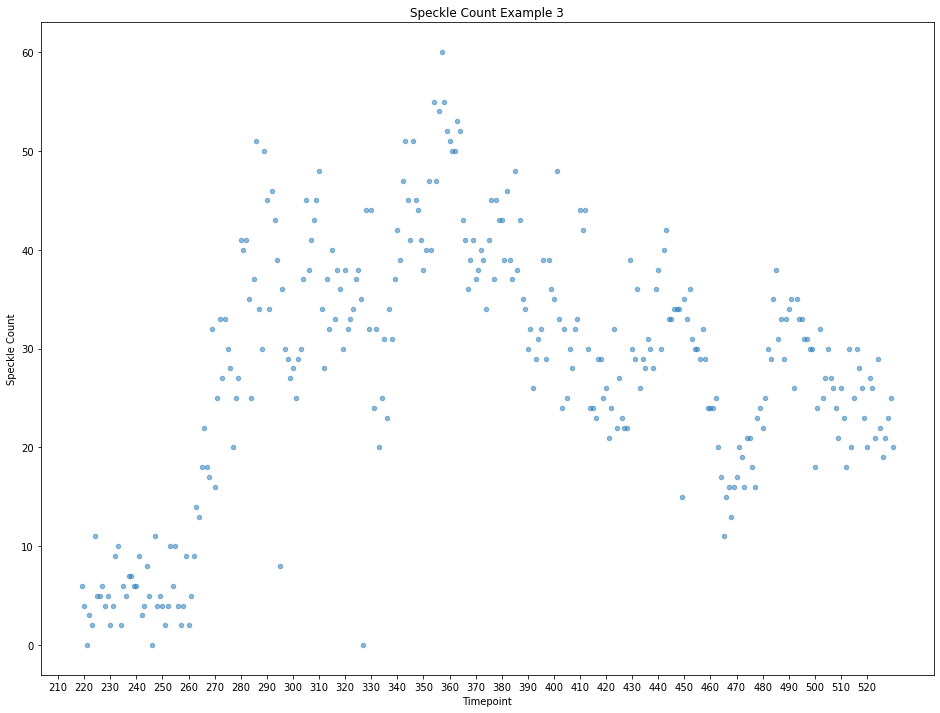

In [15]:
# Plot timepoint vs speckle count
speckle_count3_df.plot.scatter(x="Timepoint", y="Speckle Count", alpha = 0.5)
listOf_Xticks = np.arange(210, 530, 10)
plt.xticks(listOf_Xticks)
plt.title("Speckle Count Example 3")
plt.show()

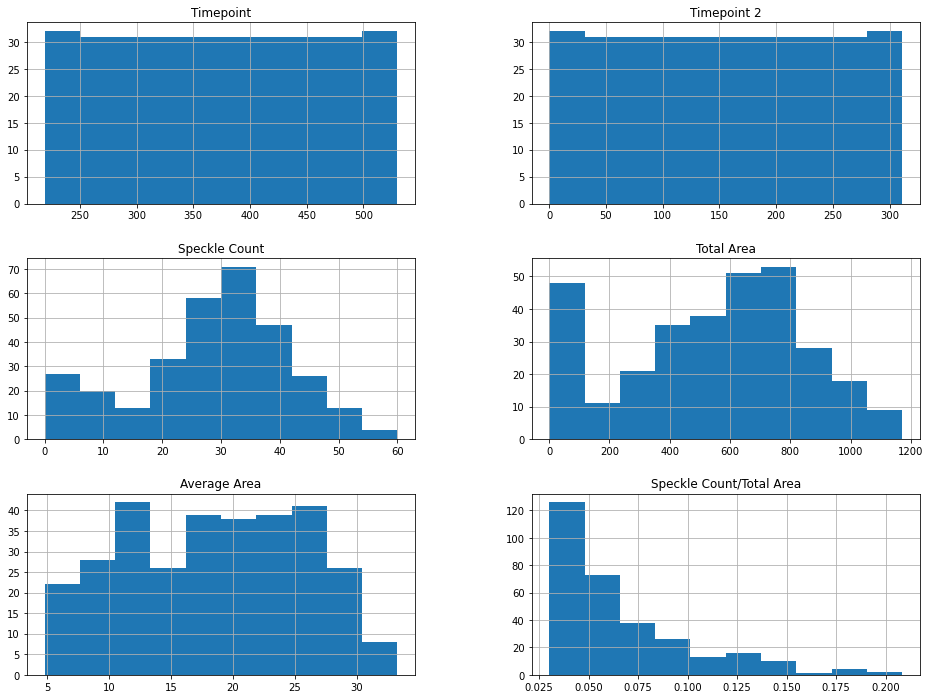

In [16]:
# # make a histogram
hist3 = speckle_count3_df.hist(bins=10) 

In [17]:
# write a function that iterates through each MIP seg image and COUNTS the number of speckles in an image 
input_directory = "/allen/aics/assay-dev/users/Sandi/nuc-morph-analysis/speckle-analysis/examples/example-2-max-projections"

speckle_count_list = []
timepoint_list = []
area_list_final = []
total_area_list = []
avg_area_list = []
count2_tp2_list = list(range(0,231))


for file in os.listdir(input_directory):
    

    structure_channel = 0
    
    # reading in file
    filename = os.path.join(input_directory, file)
    reader = AICSImage(filename) 
    IMG = reader.data.astype(np.float32)
    image = IMG[0,structure_channel,:,:,:].copy()
    image_squeeze = np.squeeze(image)
    
    # creating dataframe with region props 
    label_img = label(image_squeeze)
    regions = regionprops(label_img)
    props = regionprops_table(label_img,properties=('centroid',
                                             'bbox',
                                             'orientation',
                                             'major_axis_length',
                                             'minor_axis_length',
                                                'area'))

    regionprops_df = pd.DataFrame(props)
    
    # creating variable of total speckle count per timepoint; add to list
    speckle_count = regionprops_df.shape[0]
    speckle_count_list.append(speckle_count)
    
    # create timepoint; add to list
    timepoint_int = int(filename[-8:-5])
    timepoint_list.append(timepoint_int)
    
    # create area variable; add to list
    area_list_final = list(regionprops_df['area'])
    
    # creating total area variable; add to list
    total_area = regionprops_df['area'].sum()
    total_area_list.append(total_area)
    
    # creating average area variable; add to list
    avg_area = regionprops_df['area'].mean()
    avg_area_list.append(avg_area)
    

# empty dataframe where you'll save data
speckle_count2_df = pd.DataFrame({'Timepoint': timepoint_list, 'Timepointy 2': count2_tp2_list, 'Speckle Count': speckle_count_list,
                                 'Total Area': total_area_list, 'Average Area': avg_area_list})

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


In [18]:
speckle_count2_df = pd.DataFrame({'Timepoint': timepoint_list, 'Timepoint 2': count2_tp2_list, 'Speckle Count': speckle_count_list,
                                 'Total Area': total_area_list, 'Average Area': avg_area_list})

In [36]:
# create new column: speckle count divided by total area 
speckle_count2_df['Speckle Count/Total Area'] = speckle_count2_df['Speckle Count']/speckle_count2_df['Total Area']

# create new column: speckle count divided by total area 
speckle_count2_df['Speckle Count/Average Area'] = speckle_count2_df['Speckle Count']/speckle_count2_df['Average Area']

In [37]:
speckle_count2_df.head()

,Timepoint,Timepoint 2,Speckle Count,Total Area,Average Area,Speckle Count/Total Area,Speckle Count/Average Area
0,299,0,38,618,16.263158,0.061489,2.336570
1,300,1,38,616,16.210526,0.061688,2.344156
2,301,2,37,589,15.918919,0.062818,2.324278
3,302,3,33,664,20.121212,0.049699,1.640060
4,303,4,32,679,21.218750,0.047128,1.508100


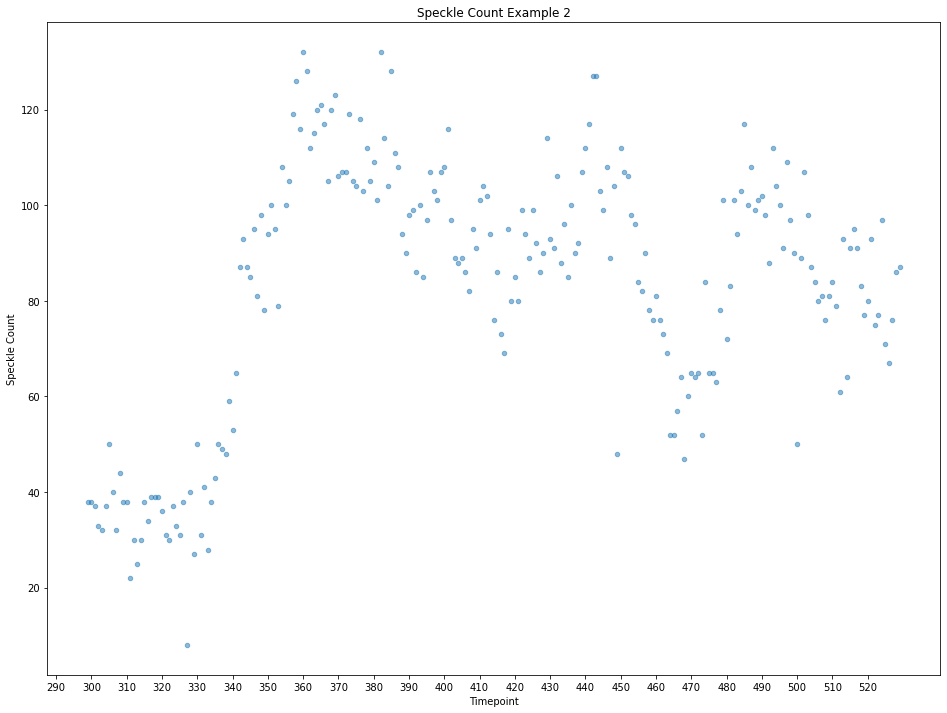

In [21]:
# Plot timepoint vs speckle count
speckle_count2_df.plot.scatter(x="Timepoint", y="Speckle Count", alpha = 0.5)
listOf_Xticks = np.arange(290, 530, 10)
plt.xticks(listOf_Xticks)
plt.title("Speckle Count Example 2")
plt.show()

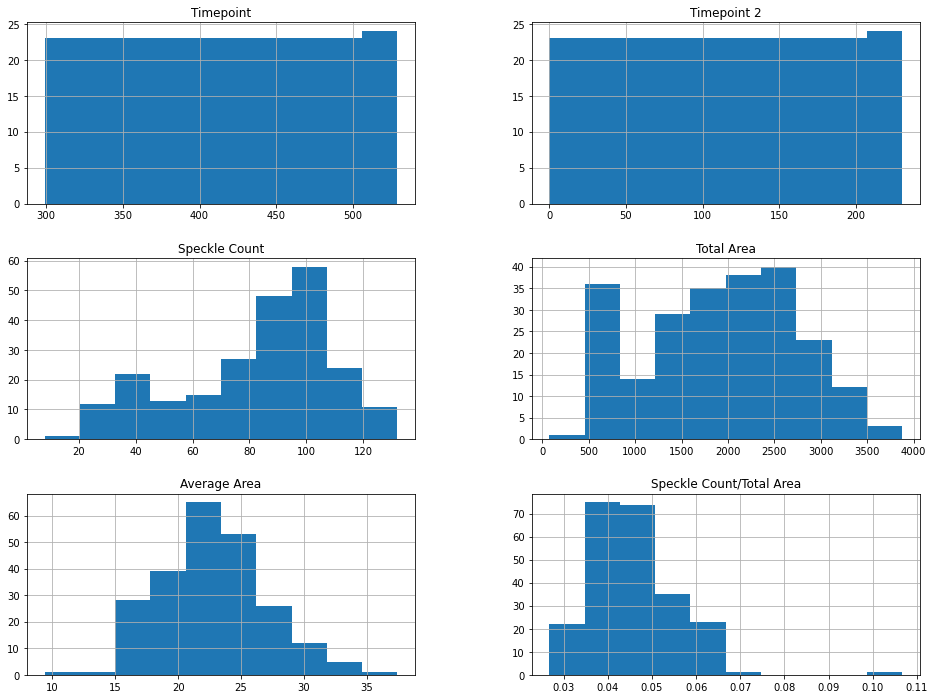

In [22]:
hist2 = speckle_count2_df.hist(bins=10) 

In [25]:
# write a function that iterates through each MIP seg image and COUNTS the number of speckles in an image 
input_directory = "/allen/aics/assay-dev/users/Sandi/nuc-morph-analysis/speckle-analysis/examples/example-1-max-projections"

speckle_count_list = []
timepoint_list = []
total_area_list=[]
avg_area_list = []
count1_tp2_list = list(range(0,430))

for file in os.listdir(input_directory):
    
    structure_channel = 0
    
    # reading in file
    filename = os.path.join(input_directory, file)
    reader = AICSImage(filename) 
    IMG = reader.data.astype(np.float32)
    image = IMG[0,structure_channel,:,:,:].copy()
    image_squeeze = np.squeeze(image)
    
    # creating dataframe with region props 
    label_img = label(image_squeeze)
    regions = regionprops(label_img)
    props = regionprops_table(label_img,properties=('centroid',
                                             'bbox',
                                             'orientation',
                                             'major_axis_length',
                                             'minor_axis_length',
                                                'area'))

    regionprops_df = pd.DataFrame(props)
    
    # creating variable of total speckle count per timepoint; add to list
    speckle_count = regionprops_df.shape[0]
    speckle_count_list.append(speckle_count)
    
    # create timepoint; add to list
    timepoint_int = int(filename[-8:-5])
    timepoint_list.append(timepoint_int)
    
    # creating total area variable; add to list
    total_area = regionprops_df['area'].sum()
    total_area_list.append(total_area)
    
    # creating average area variable; add to list
    avg_area = regionprops_df['area'].mean()
    avg_area_list.append(avg_area)
    

# empty dataframe where you'll save data
speckle_count1_df = pd.DataFrame({'Timepoint': timepoint_list, 'Timepoint 2': count1_tp2_list,
                                  'Speckle Count': speckle_count_list, 'Total Area': total_area_list,
                                 'Average Area': avg_area_list})

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


UnsupportedFileFormatError: AICSImage does not support the image: '<class 'str'>'. You may need to install an extra format dependency. See all known format extensions and their extra install name with `aicsimageio.formats.FORMAT_IMPLEMENTATIONS`.

In [26]:
speckle_count1_df = pd.DataFrame({'Timepoint': timepoint_list, 'Timepoint 2': count1_tp2_list,
                                  'Speckle Count': speckle_count_list, 'Total Area': total_area_list,
                                 'Average Area': avg_area_list})

In [34]:
# create new column: speckle count divided by total area 
speckle_count1_df['Speckle Count/Total Area'] = speckle_count1_df['Speckle Count']/speckle_count1_df['Total Area']

# create new column: speckle count divided by total area 
speckle_count1_df['Speckle Count/Average Area'] = speckle_count1_df['Speckle Count']/speckle_count1_df['Average Area']

In [35]:
speckle_count1_df.head()

,Timepoint,Timepoint 2,Speckle Count,Total Area,Average Area,Speckle Count/Total Area,Speckle Count/Average Area
0,100,0,20,356,17.800000,0.056180,1.123596
1,101,1,26,391,15.038462,0.066496,1.728900
2,102,2,27,534,19.777778,0.050562,1.365169
3,103,3,35,557,15.914286,0.062837,2.199282
4,104,4,37,584,15.783784,0.063356,2.344178


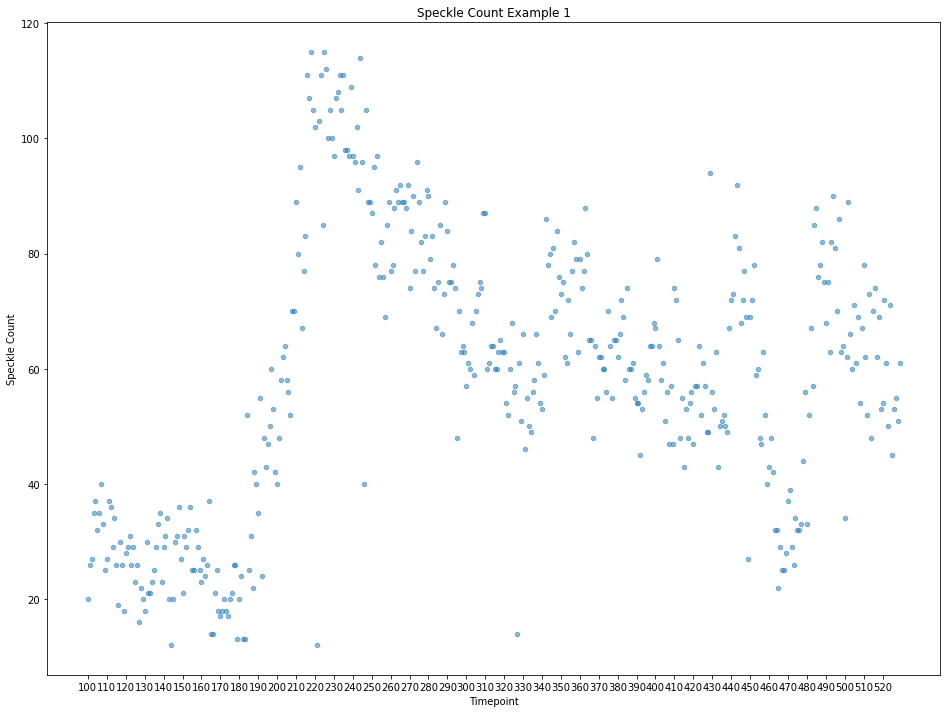

In [29]:
# Plot timepoint vs speckle count
speckle_count1_df.plot.scatter(x="Timepoint", y="Speckle Count", alpha = 0.5)
listOf_Xticks = np.arange(100, 530, 10)
plt.xticks(listOf_Xticks)
plt.title("Speckle Count Example 1")
plt.show()

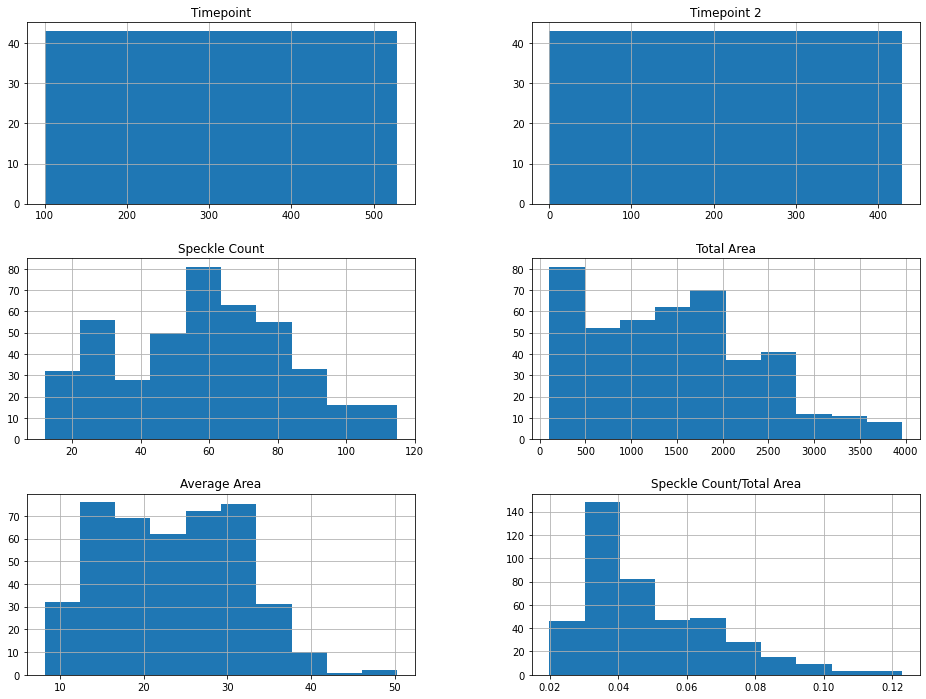

In [30]:
hist1 = speckle_count1_df.hist(bins=10) 

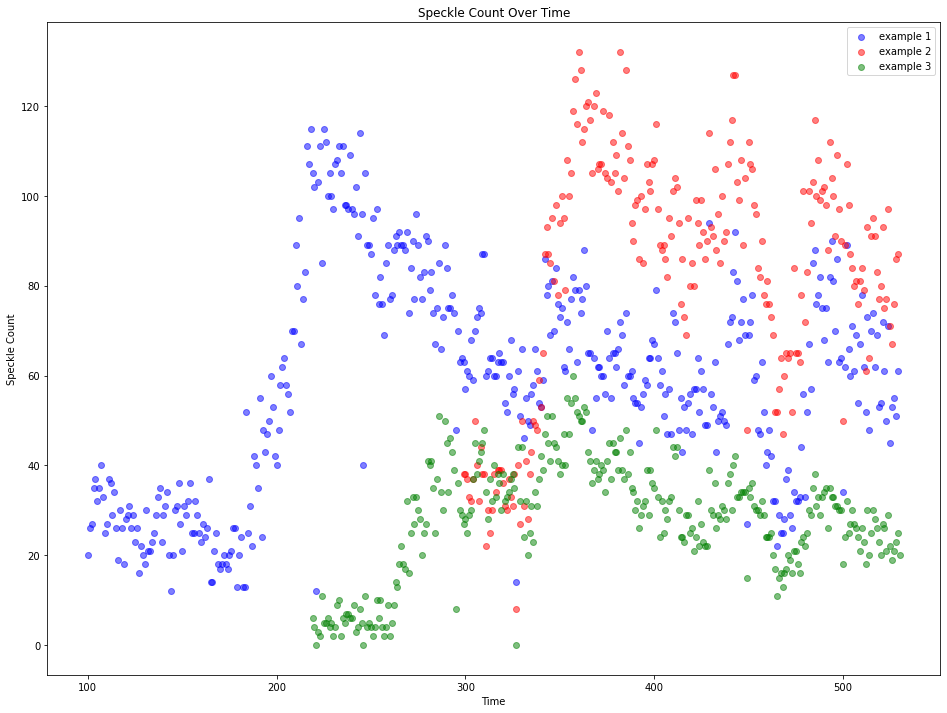

In [31]:
# plotting all examples on the same graph

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x=speckle_count1_df["Timepoint"], y=speckle_count1_df["Speckle Count"], c='b', label='example 1', alpha = 0.5)
ax1.scatter(x=speckle_count2_df["Timepoint"], y=speckle_count2_df["Speckle Count"], c='r', label='example 2', alpha = 0.5)
ax1.scatter(x=speckle_count3_df["Timepoint"], y=speckle_count3_df["Speckle Count"], c='g',label='example 3', alpha = 0.5)

listOf_Xticks = np.arange(100, 530, 10)
# ax1.xticks(listOf_Xticks)
plt.title("Speckle Count Over Time")
plt.legend(loc='upper right')
ax1.set_xlabel("Time")
ax1.set_ylabel("Speckle Count")
plt.show()

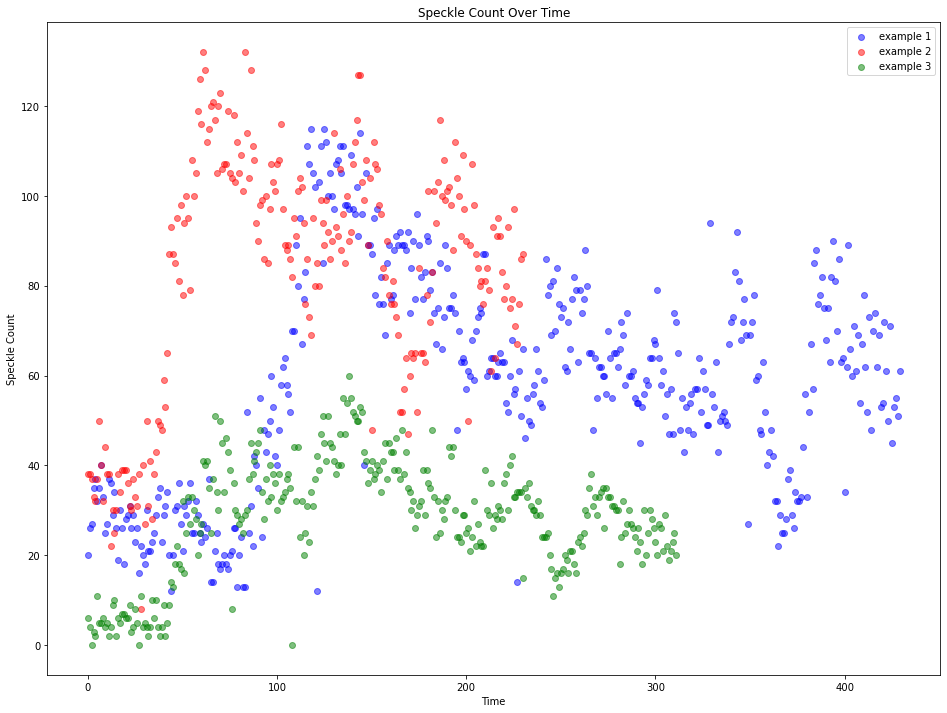

In [32]:
# SPECKLE COUNT OVER TIME

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x=speckle_count1_df["Timepoint 2"], y=speckle_count1_df["Speckle Count"], c='b', label='example 1', alpha = 0.5)
ax1.scatter(x=speckle_count2_df["Timepoint 2"], y=speckle_count2_df["Speckle Count"], c='r', label='example 2', alpha = 0.5)
ax1.scatter(x=speckle_count3_df["Timepoint 2"], y=speckle_count3_df["Speckle Count"], c='g',label='example 3', alpha = 0.5)

listOf_Xticks = np.arange(100, 530, 10)
# ax1.xticks(listOf_Xticks)
plt.title("Speckle Count Over Time")
plt.legend(loc='upper right')
ax1.set_xlabel("Time")
ax1.set_ylabel("Speckle Count")
plt.show()

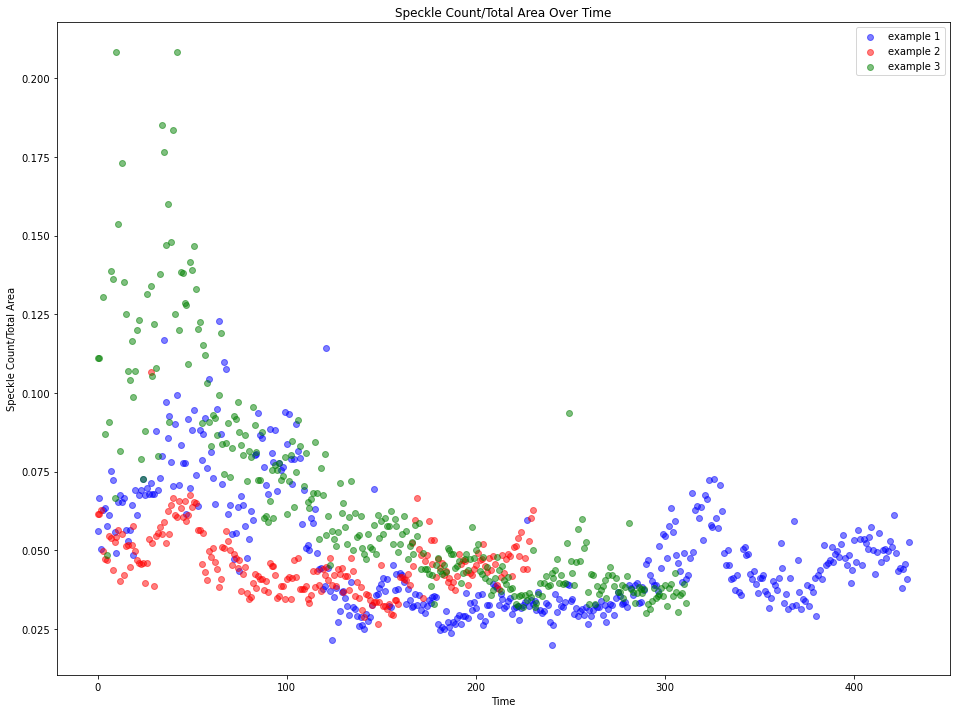

In [43]:
# SPECKLE COUNT/TOTAL AREA OVER TIME 
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x=speckle_count1_df["Timepoint 2"], y=speckle_count1_df["Speckle Count/Total Area"], c='b', label='example 1', alpha = 0.5)
ax1.scatter(x=speckle_count2_df["Timepoint 2"], y=speckle_count2_df["Speckle Count/Total Area"], c='r', label='example 2', alpha = 0.5)
ax1.scatter(x=speckle_count3_df["Timepoint 2"], y=speckle_count3_df["Speckle Count/Total Area"], c='g',label='example 3', alpha = 0.5)

listOf_Xticks = np.arange(100, 530, 10)
# ax1.xticks(listOf_Xticks)
plt.title("Speckle Count/Total Area Over Time")
plt.legend(loc='upper right')
ax1.set_xlabel("Time")
ax1.set_ylabel("Speckle Count/Total Area")
plt.show()

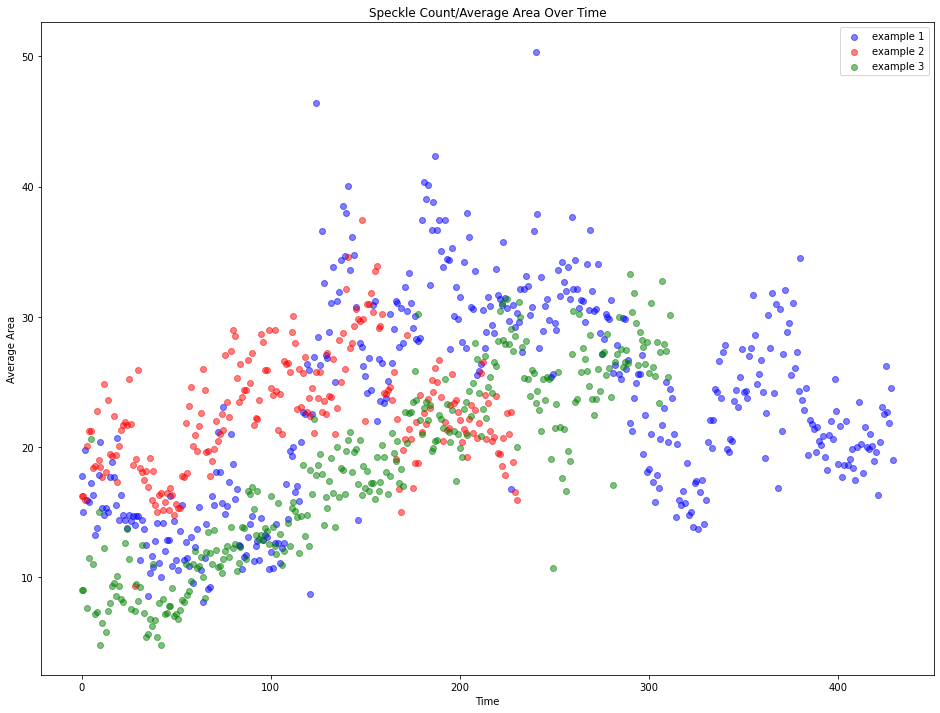

In [45]:
# SPECKLE COUNT/AVERAGE AREA OVER TIME 
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x=speckle_count1_df["Timepoint 2"], y=speckle_count1_df["Average Area"], c='b', label='example 1', alpha = 0.5)
ax1.scatter(x=speckle_count2_df["Timepoint 2"], y=speckle_count2_df["Average Area"], c='r', label='example 2', alpha = 0.5)
ax1.scatter(x=speckle_count3_df["Timepoint 2"], y=speckle_count3_df["Average Area"], c='g',label='example 3', alpha = 0.5)

listOf_Xticks = np.arange(100, 530, 10)
# ax1.xticks(listOf_Xticks)
plt.title("Speckle Count/Average Area Over Time")
plt.legend(loc='upper right')
ax1.set_xlabel("Time")
ax1.set_ylabel("Average Area")
plt.show()

In [ ]:
# OLD CODE

In [66]:
# # create bounding box for each speckle

# fig, ax = plt.subplots()
# ax.imshow(image_squeeze, cmap=plt.cm.gray)

# for props in regions:
#     y0, x0 = props.centroid
#     orientation = props.orientation
#     x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
#     y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
#     x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
#     y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

#     ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
#     ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
#     ax.plot(x0, y0, '.g', markersize=15)

#     minr, minc, maxr, maxc = props.bbox
#     bx = (minc, maxc, maxc, minc, minc)
#     by = (minr, minr, maxr, maxr, minr)
#     ax.plot(bx, by, '-b', linewidth=2.5)

# ax.axis((0, 170, 258, 0))
# plt.show()

# # speckle count 

# n_white_pix = np.sum(image_squeeze == 255)
# print('Number of white pixels:', n_white_pix)